# Condition and process the HAT-P-37 data
Edited 4/16 to run through entire processing of sector to transit midtimes for a Tess sector that is contaminated by the EB

In [54]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import Quantity
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# From A-thano et. al. (https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract)
orbital_period = 2.79744256 #±0.00000041 
epoch_0 = 2457938.84392 # ±0.00016
# convert t0 to TESS BJD (BTJD)
epoch_0_BTJD = epoch_0 - 2457000.

## Start by downloading all available sectors of TESS data for HAT-P-37 b

In [8]:
# Check which lightcurves are available for HAT-P-37
# I can't seem to look the system up except by its TIC number
# exptime='short' only keeps the 120-s exposures
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

# As of 4/16/25 there should be 11 sectors

LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

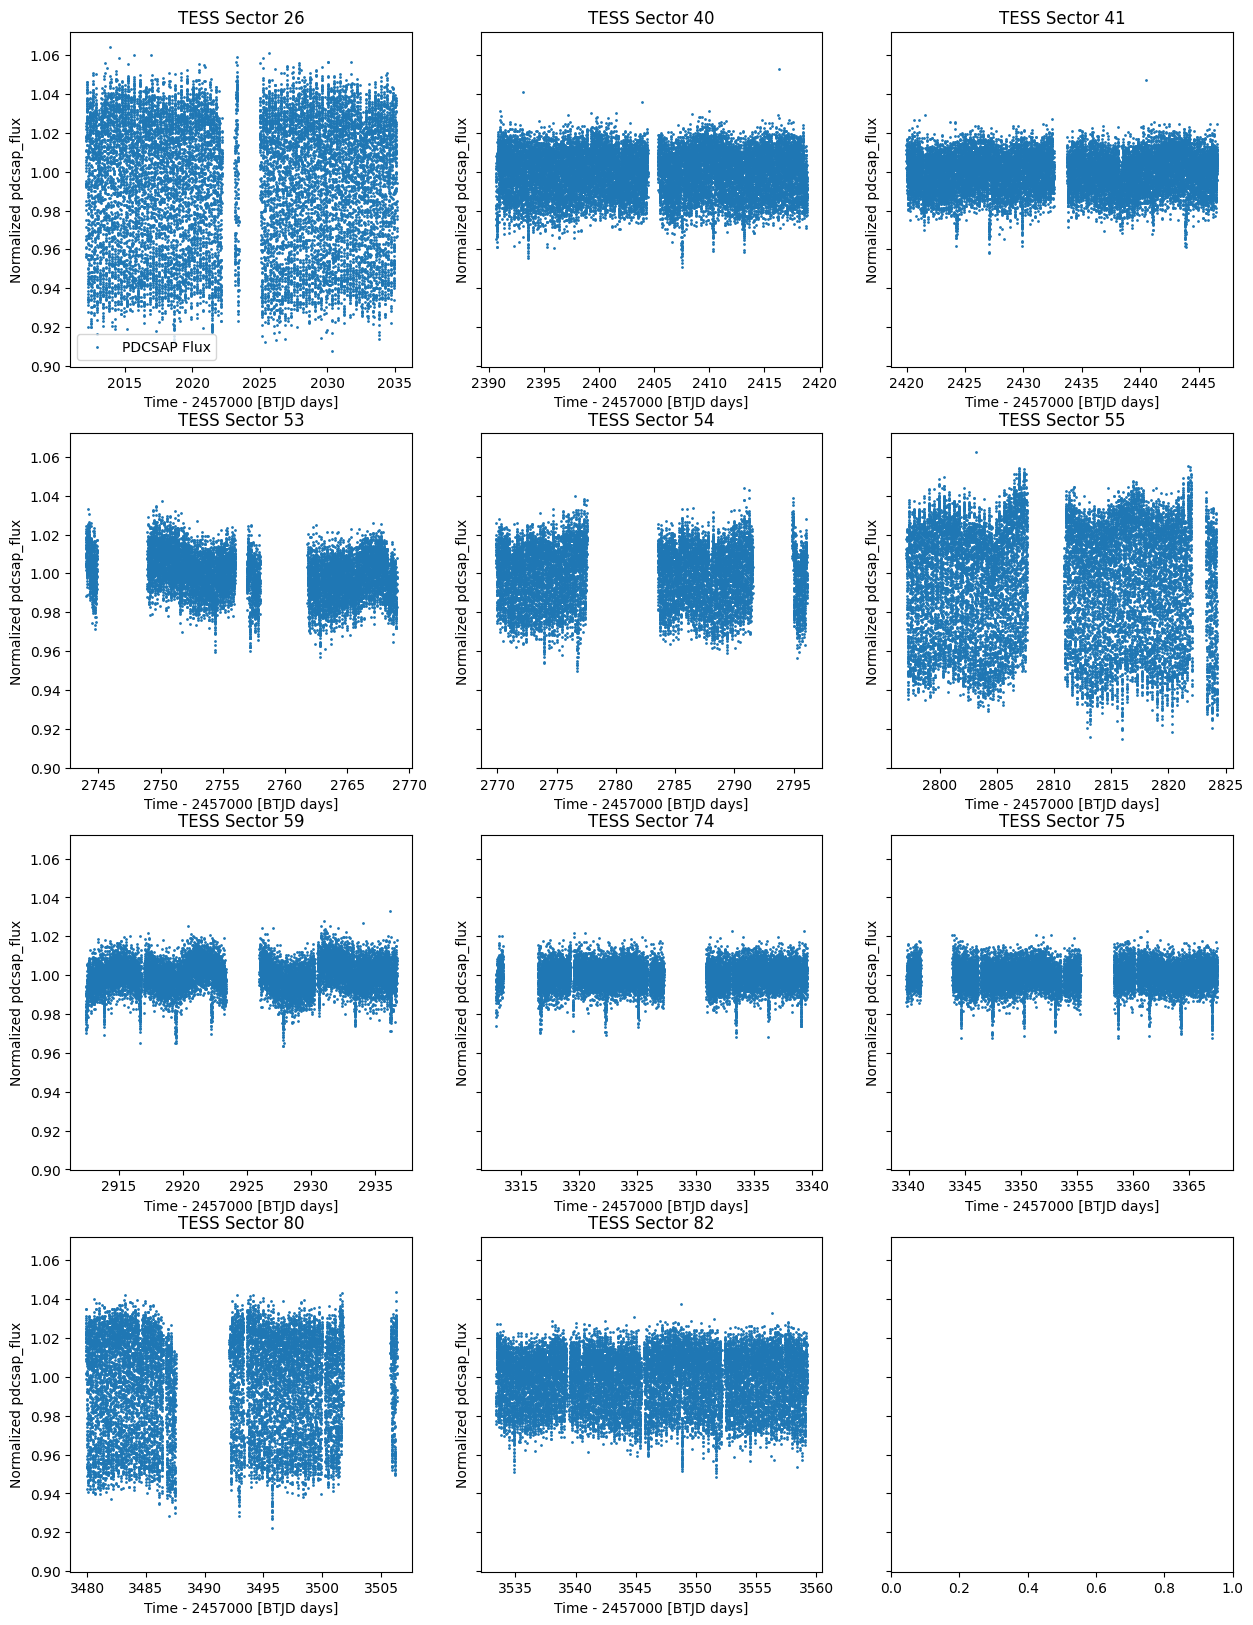

In [44]:
# PDCSAP_FLUX is the mission's estimate for lightcurve with instrument effects taken out
# Plot the PDCSAP flux after 3.0 sigma clipping for each tess sector
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

cleaned_lcs = []
for i, lc in enumerate(tess_lc_collection):
    no_nans_lc = lc.remove_nans()
    clipped_lc = no_nans_lc.remove_outliers(sigma=5.0)

    cleaned_lcs.append(clipped_lc)

    clipped_lc.scatter(column='pdcsap_flux', label='PDCSAP Flux', normalize=True, ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    if i == 0:
        axs[ax_indices[i]].legend()  # keep the legend in the first plot
    else:
        axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

fig.savefig("figures/allSectors_sigma5_PDCSAPflux_lc.png", dpi=300, bbox_inches="tight")

## Calculate the period of the EB and identify contaminated sectors

In [10]:
# calculate the t0 for the eclipsing binary (from https://iopscience.iop.org/article/10.3847/1538-4365/ab9cae#apjsab9caes5)
HJD_shift = 2400000.5
EB_t0_HJD = 58641.4289616 + HJD_shift
# print(EB_t0_HJD)
EB_t0_BJD = 2458641.929750  # calculated using the Ohio State Applet (https://astroutils.astronomy.osu.edu/time/hjd2bjd.html)
# finally convert t0 to TESS BJD (BTJD)
EB_t0_BTJD = EB_t0_BJD - 2457000.
print(EB_t0_BTJD)

1641.9297500001267


### Use the Box Least Squares method to analyze the periodogram

Excluded Sector:  59 2.796216164491639 d
Excluded Sector:  74 2.7978807389073808 d
Excluded Sector:  75 2.795156352624111 d


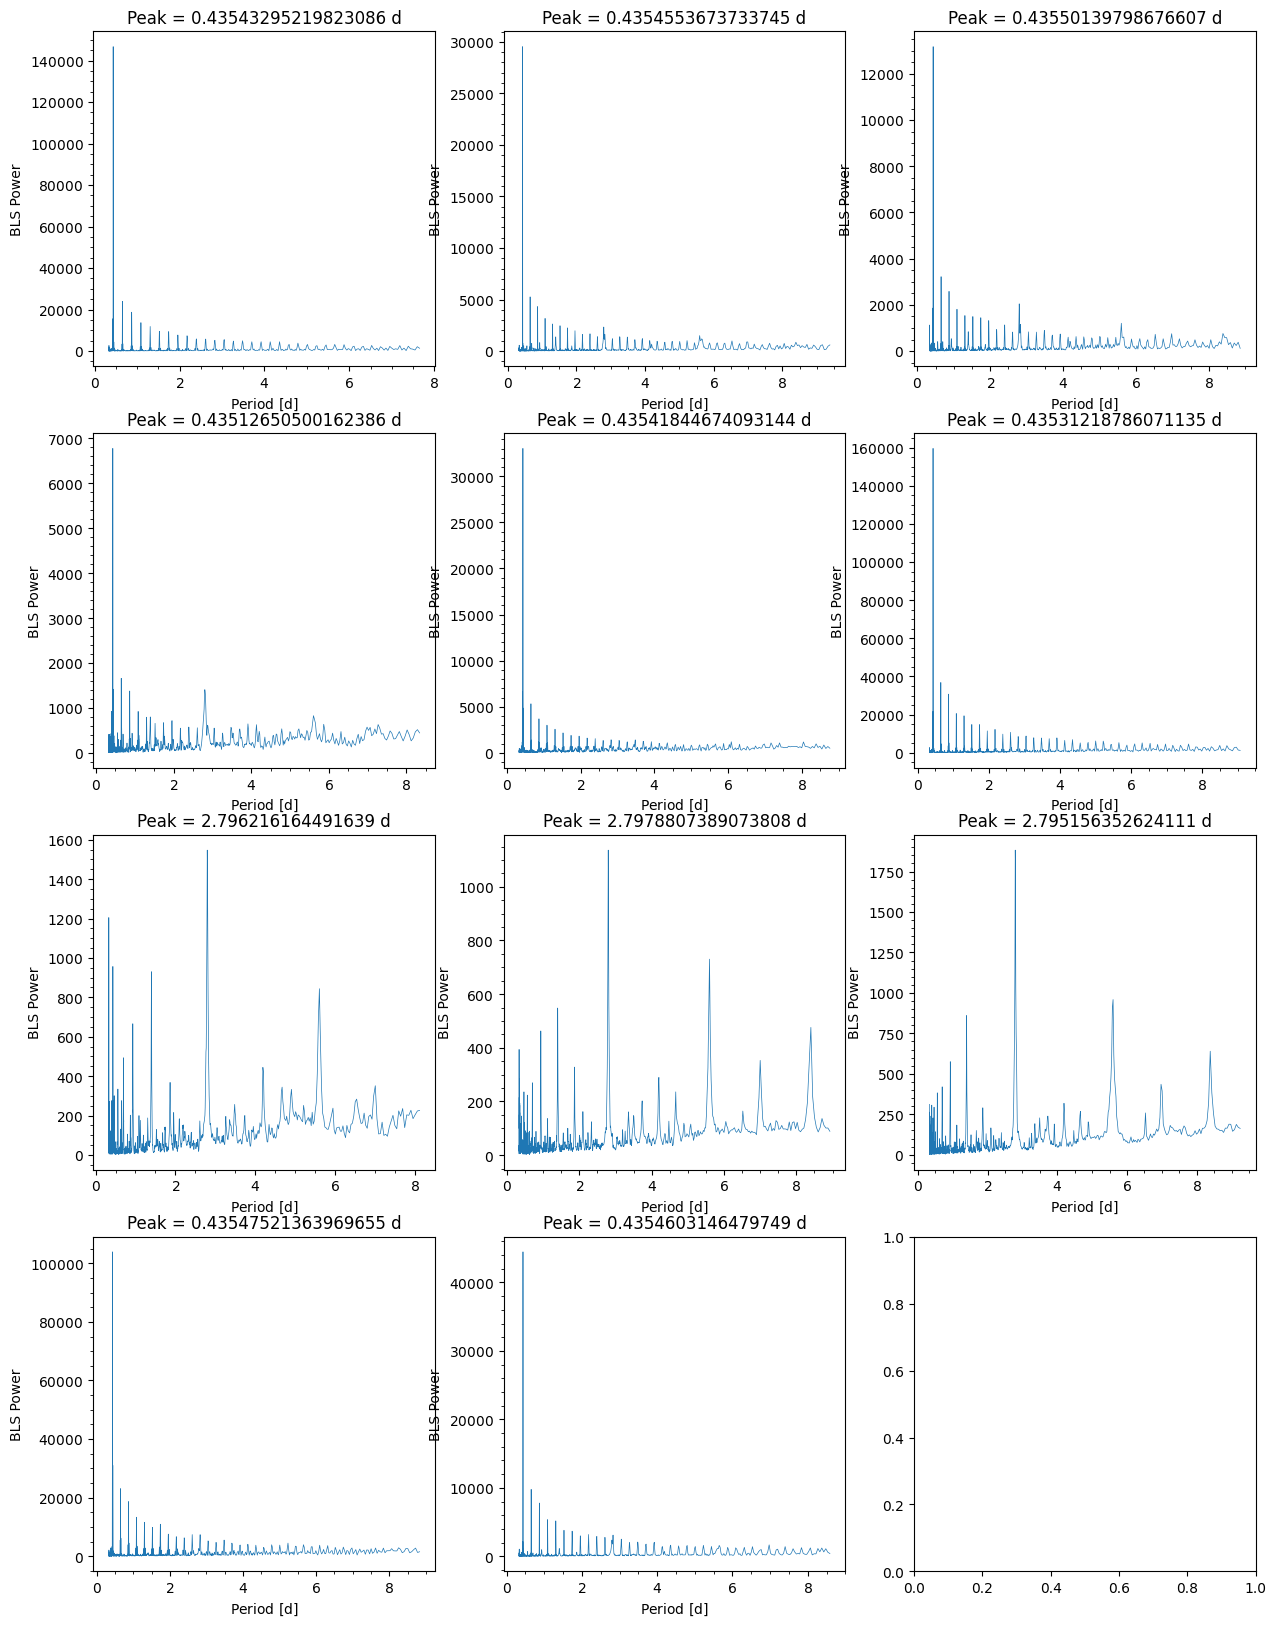

In [45]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period_by_sector = []
sum_period = 0
BLS_EB_list = []
for i, lc in enumerate(cleaned_lcs):
    pg = lc.to_periodogram(method="bls")
    pg.plot(ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    if pg.period_at_max_power >= Quantity(1, "day"):  # do not include data that captures planet's period
        print("Excluded Sector: ", lc.sector, pg.period_at_max_power)
    else:
        average_period_by_sector.append(pg.period_at_max_power)
        sum_period += pg.period_at_max_power
        BLS_EB_list.append(lc)

# after calculating the peak for each sector, divde by number of sectors with the EB period to get the average period
BLS_avg_EB_period = sum_period / len(BLS_EB_list) 

fig.savefig("figures/allSectors_BLS_periodogram.png", dpi=300, bbox_inches='tight')

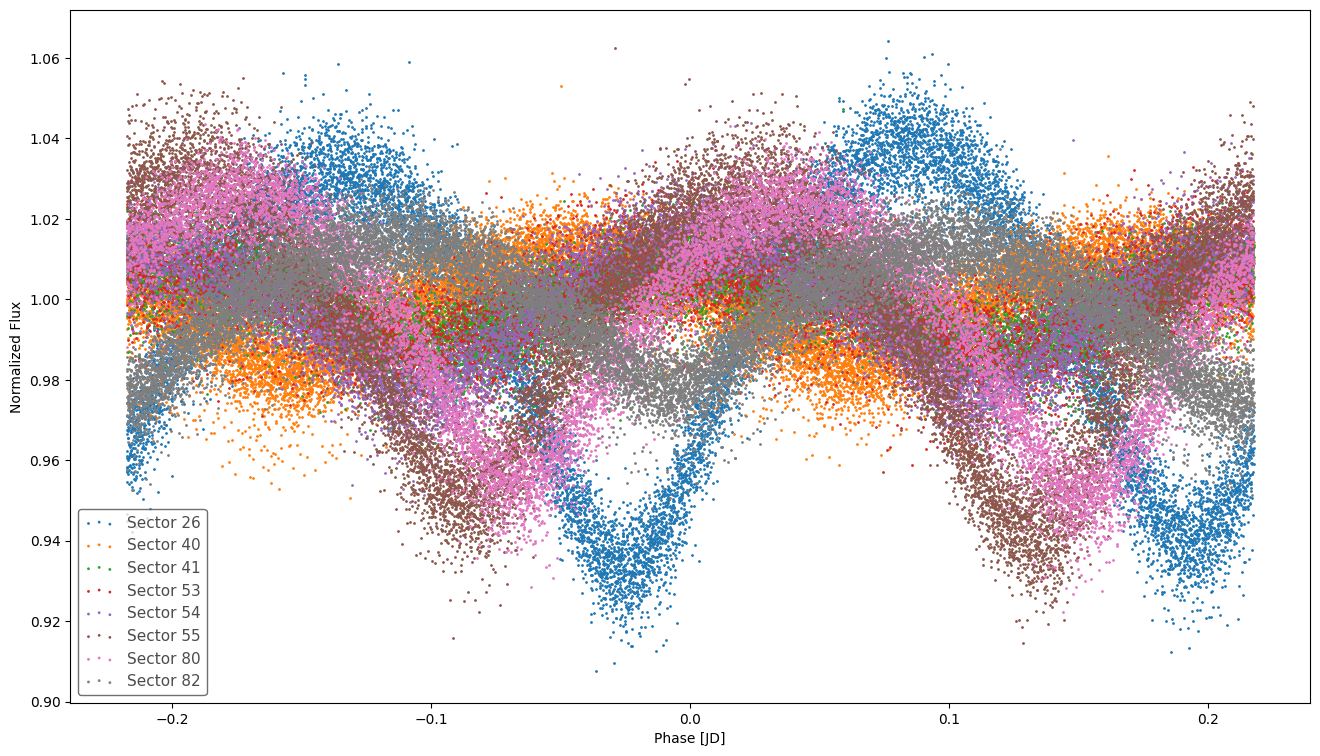

In [47]:
# for each sector that returns a period appropriate for the binary, fold according to the average EB period and plot
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for i, lc in enumerate(BLS_EB_list):
    folded_lc = lc.fold(period=average_period_by_sector[i])
    folded_lc.scatter(ax=ax, label=f"Sector {folded_lc.sector}", normalize=True);

fig.savefig("Figures/ContaminatedSectors_EBfolded.png", dpi=300, bbox_inches="tight")

As we can tell from this plot, the level of contamination in each sector is different. Therefore, we will make an effort to individually fit each sector. 

### Starting here, we will define functions for each process so they can be applied sector by sector as needed. 

In [48]:
# create a transit mask, use the argument 'plot_data=True' for a sanity check of the mask
def mask_transits(sector_lk, plot_data=False):
    '''returns lightkurve object of a full sector without the transits, sector_lk MUST be a lightkurve LightCurve obj'''
    known_transit_mask = sector_lk.create_transit_mask(transit_time=epoch_0_BTJD, 
                                                   period=orbital_period,
                                                   duration=0.1)
    # NOTE: create transit mask returns an array with True for every data point IN TRANSIT, so we need to flip it to remove the transits
    no_transit_mask = known_transit_mask == False  # this inverts the mask to mask out ONLY the transits
    NO_transits_lk = sector_lk[no_transit_mask]

    if plot_data:
        fig = plt.figure()
        ax=fig.add_subplot(111)
        sector_lk.scatter(ax=ax, normalize=True, color='k', label="All Data")
        NO_transits_lk.scatter(ax=ax, normalize=True, label="Transits Masked")
        ax.get_legend() 
        fig.savefig(f"figures/FullSector_{sector_lk.sector}_NO_transits.png", dpi=300, bbox_inches="tight")

    return NO_transits_lk           


In [ ]:
# Ran to create all the masked transit plots.
for lk_obj in BLS_EB_list:
    no_transits = mask_transits(lk_obj, plot_data=True)

In [70]:
# create a binned and folded lightcurve
# NOTE: Since the orbital period is an argument these functions can be used for either the EB or the planet orbital period. 

def bin_lightcurve(lightcurve, binsize=120./86400.):  # 120 seconds to days
    time = lightcurve.time.value
    flux = lightcurve.flux.value 
    
    binned_time = np.array([])
    binned_flux = np.array([])
    binned_err = np.array([])

    cur_point = np.min(time) + 0.5*binsize
    while(cur_point <= np.max(time) - 0.5*binsize):
        ind = np.abs(cur_point - time) < 0.5*binsize

        if(len(time[ind]) > 0):
            binned_time = np.append(binned_time, np.mean(time[ind]))
            binned_flux = np.append(binned_flux, np.mean(flux[ind]))
            binned_err = np.append(binned_err, np.std(flux[ind]))
        
        cur_point += binsize

    binned_lightcurve = lk.LightCurve(time=binned_time, flux=binned_flux, flux_err=binned_err)
    return binned_lightcurve


def fold_lightcurve(lightcurve, period, ref_mid, output_rel_times=False):
    # return a lightkurve object with the time folded
    print(f"Folding to period {period} with ref mid {ref_mid}")
    times = lightcurve.time.value
    rel_times = times - ref_mid - period/2. # to plot transit in center
    mod_rel_times = rel_times % period
    
    if output_rel_times:
        folded_lightcurve = lk.LightCurve(time=mod_rel_times, flux=lightcurve.flux, flux_err=lightcurve.flux_err)
    else: 
        folded_times_assigned_mid_sector = mod_rel_times+ref_mid-period/2.
        folded_lightcurve = lk.LightCurve(time=folded_times_assigned_mid_sector, flux=lightcurve.flux, flux_err=lightcurve.flux_err)
    return folded_lightcurve

Folding to period 0.43543295219823086 with ref mid 1641.9297500001267
Folding to period 0.4354553673733745 with ref mid 1641.9297500001267
Folding to period 0.43550139798676607 with ref mid 1641.9297500001267
Folding to period 0.43512650500162386 with ref mid 1641.9297500001267
Folding to period 0.43541844674093144 with ref mid 1641.9297500001267
Folding to period 0.43531218786071135 with ref mid 1641.9297500001267
Folding to period 0.43547521363969655 with ref mid 1641.9297500001267
Folding to period 0.4354603146479749 with ref mid 1641.9297500001267


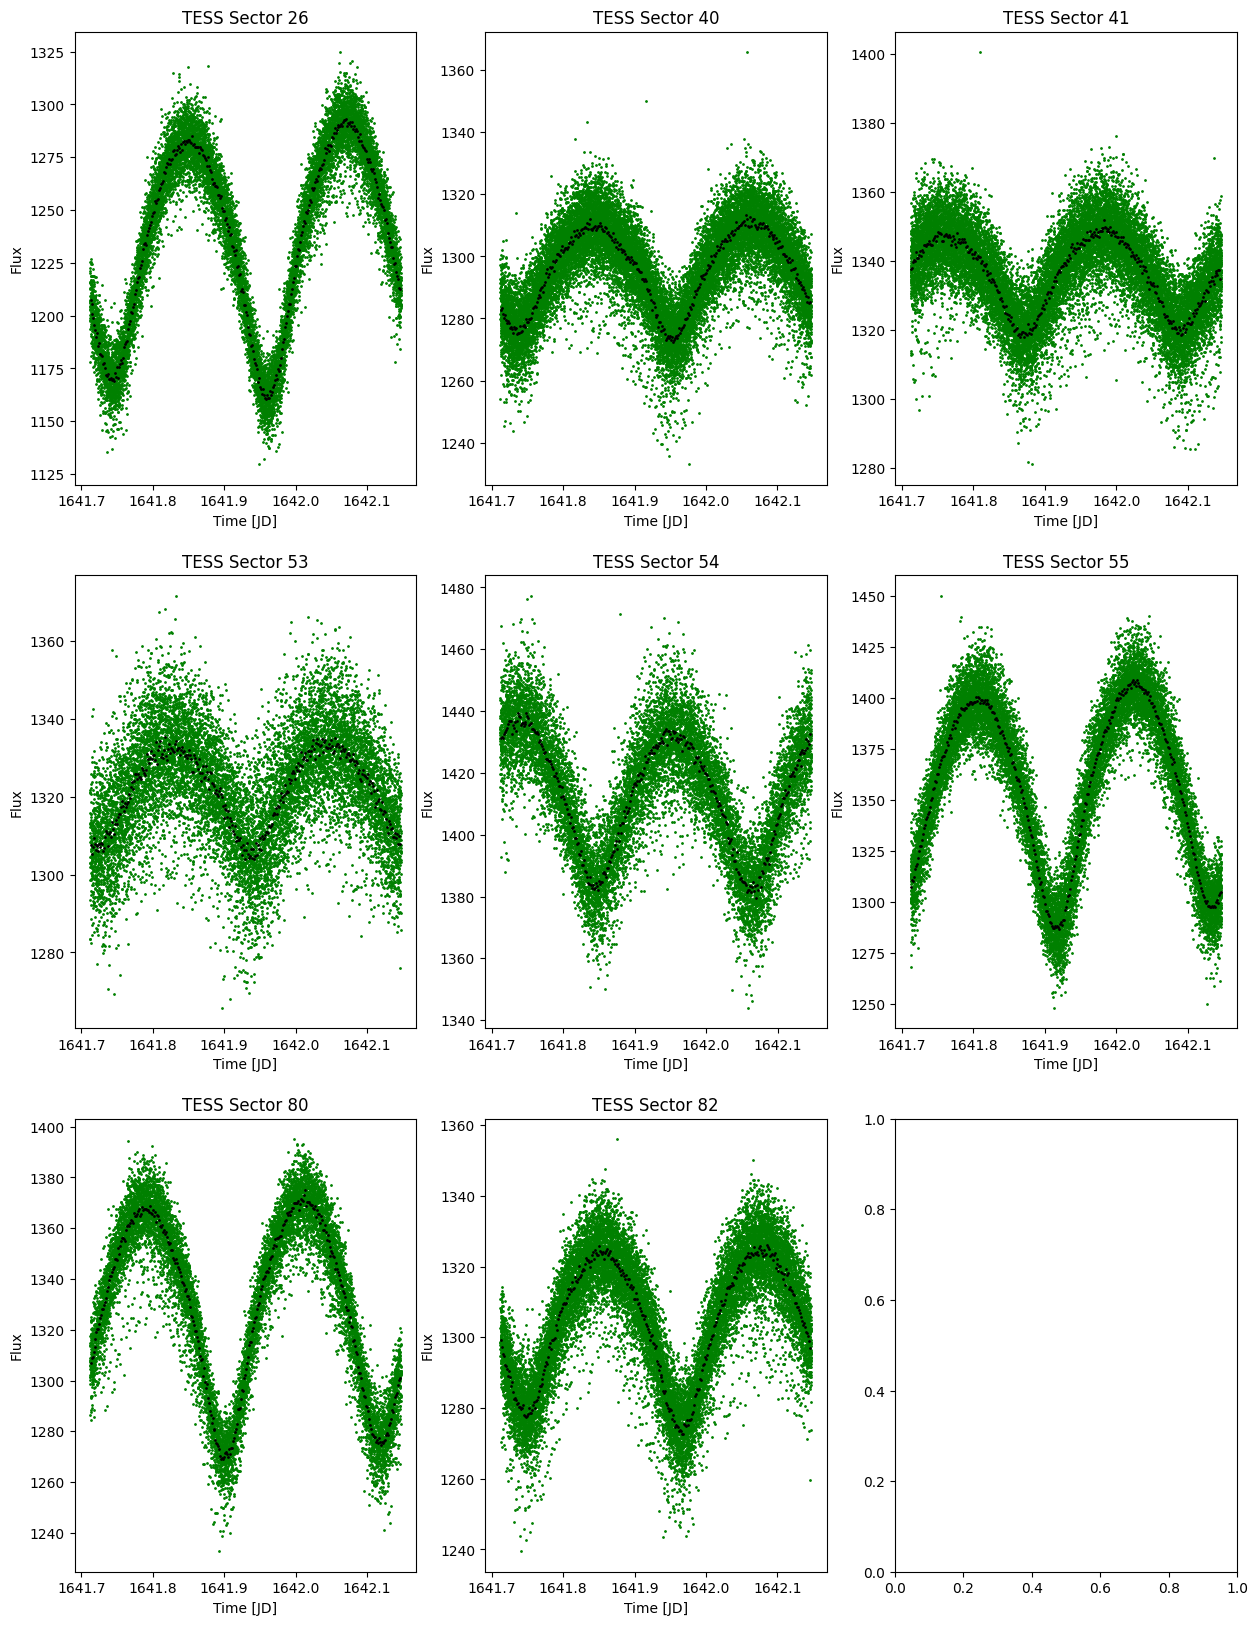

In [71]:
# Try phase folding each sector individually. 
fig, axs = plt.subplots(3, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

for i, lc in enumerate(BLS_EB_list):
    folded_lc = fold_lightcurve(lc, period=average_period_by_sector[i].value, ref_mid=EB_t0_BTJD)
    binned_folded_lc = bin_lightcurve(folded_lc)
    folded_lc.scatter(ax=axs[ax_indices[i]], color="g", zorder=-1)
    binned_folded_lc.scatter(ax=axs[ax_indices[i]], color='k')
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")

fig.savefig("Contamined_bySector_foldbin_assignedtimes.png", dpi=300, bbox_inches="tight")

In [ ]:
def detrend_w_SavGol(sector_lc, binary_period, epoch_0_BTJD, orbital_period):
    masked_lc = mask_transits(sector_lc) # Mask out transit
    folded_lc = fold_lightcurve(masked_lc, period=binary_period)
    binned_lc = bin_lightcurve(folded_lc) # default bins to 120s 

    # Now interpolate across whole time-series unfolded
    interp_trend = np.interp(folded_lc.time.value, binned_lc.time.value, binned_lc.time.value)

    detrended_flux = cur_flux / interp_trend
    plt.scatter(cur_time % orbital_period, detrended_flux, marker='.') 

    return cur_time, detrended_flux

In [64]:
test = fold_lightcurve(BLS_EB_list[1], period=average_period_by_sector[1].value)
print(test.time.value)

[0.00512629 0.00651519 0.00790409 ... 0.3333999  0.33478879 0.33617768]


In [ ]:
# finally, use the fourier transform function to divide through FULL sector data to remove the EB

fig, axs = plt.subplots(3, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
# popt_fourier_bf_data

for i, lc in enumerate(BLS_list):  # full sector light curves that are contaiminated by the EB
    # First plot all the sectors folded to the transit period. 
    transit_folded_lc = lc.fold(period=orbital_period, epoch_time=epoch_0_BTJD)  # by not defining an epoch_time, we make it so that the EB fold and transit fold start at the same time
    # transit_folded_lc.scatter(ax=axs[ax_indices[i]])
    transit_binned = transit_folded_lc.bin(binsize)
    transit_binned.scatter(ax=axs[ax_indices[i]])
    
    # how many EB phases are in a transit phase
    # print(average_period[i])
    EB_per_transit = orbital_period / average_period[i].value
    # print(f"There are {EB_per_transit} eclipses in one transit period of Sector {transit_folded_lc.sector}")
    # new_x = np.linspace(0, EB_per_transit*2*np.pi, len(transit_folded_lc.time.value), endpoint=True)  # we create a grid across the phase space we need with the length to match the data
    # fit_y = fourier_series(new_x, *popt_fourier_bf_data[i])
    # axs[ax_indices[i]].plot(transit_folded_lc.time.value, fit_y, '-', color='k', label="Fourier Series Fit")

    # flat_y = transit_folded_lc.flux / fit_y
    # axs[ax_indices[i]].plot(transit_folded_lc.time.value, flat_y, '-', color='r', label="Flattened")
    # print("Completed Sector ", transit_folded_lc.sector)
    
    # popt, pcov = curve_fit(fourier_series, fit_x, lc.flux.value, p0=true_params)
    # popt_fourier_bf_data.append(popt)

    # lc.scatter(ax=axs[ax_indices[i]])
    # new_x = np.linspace(0, 2*np.pi, 314, endpoint=True)
    # axs[ax_indices[i]].plot(phase, fourier_series(new_x, *popt), '-', color='k', label="Fourier Series Fit")
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    # axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.